### ISPR Midterm 2 Assignment 2 
<font size="4"> Paolo Fasano </font> <font size="2"> p.fasano1@studenti.unipi.it</font>

#### Section 1: The Code

The libraries used to write the code for the assignment 2 are the following:

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random 
import utility

import gensim.models
from gensim.models import LdaModel 

from scipy.cluster.vq import * 
from numpy import histogram


To extract the keypoints and the descriptors the following method has been implemented which takes in input an image, change the colors to a gray scale, than uses MRES to detect the keyPoints and SIFT to extract the descriptors.   

In [2]:
def mresSift(img):
    msr = cv2.MSER_create( ) 
    gray = cv2.cvtColor(src = img ,code = cv2.COLOR_BGR2GRAY) 
    sift = cv2.xfeatures2d.SIFT_create( ) 
    
    kp = msr.detect(gray)
    kp , des = sift.compute( gray , kp) 
    
    return kp, des

To perform the k-mean the following method has been implemented:
it builds the codebook by creating a list containing the descriptors for each image and than applying the scipy library k-mean extracting the codebook and the distances  

In [3]:
def newkM(pics, k=500):
    
    descriptors = np.array([])
    i = 0
    for pic in pics:
        if pic is not None and len(pic) > 0:
            descriptors = np.append(descriptors, pic['descriptors'])
            desc = np.reshape(descriptors, (len(descriptors)//128, 128)) 
            desc = np.float32(desc)
        print(("elaborated descriptors ", i+1, " out of ", len(pics)), end='\r')
        i+=1
    
    #codebook 
    words, distances = scipy.cluster.vq.kmeans(scipy.cluster.vq.whiten(desc), k_or_guess=500)
    print("kmean done")
    return words, distances

The following portion of the code loads the dataset and testset (using methods from the utility.py file) than performs the mresSift function.

picTrain is a list of dictionaries, each dictionary in this list contains:
- pic: the picture read using opencv
- keyPoint: all the keypoints for the pic
- descriptors: the descriptors for the pic
- code: an array holding the code book index for each observation
- histograms: the histogram created using the Bag of Visual Words      

In [4]:
pTrain, pTrainL = utility.loadFiles("./msrc_objcategimagedatabase_v1/train/")
pTrain, _ = utility.shuffleLists(pTrain,pTrainL)

pTest, pTestL = utility.loadFiles("./msrc_objcategimagedatabase_v1/test/")
pTest, _ = utility.shuffleLists(pTest,pTestL)

picTrain = []
for pic in pTrain[:200]:
    picTrain.append({'pic':pic})


picTest = []
for pic in pTest:
    picTest.append({'pic':pic})

print("dataset splitted and shuffled")

i = 0
for pic in picTrain:
    kp, des = mresSift(pic['pic'])
    picTrain[i]['keyPoint'] = kp
    picTrain[i]['descriptors'] = des
    i+=1

dataset splitted and shuffled


The k-mean is than performed using the Training picture and their keypoints and descriptors.

In [5]:
#codebook for the picTrain
picTrainWords, distances = newkM(picTrain)

kmean doneed descriptors ', 200, ' out of ', 200)


For each picture in the training set we proceed to create a Bag of Visual Words using he cluster that have been identified in the codebook (called picTrainWords in the code below). 

In [6]:
i = 0
for pic in picTrain:
        code, dist = scipy.cluster.vq.vq(scipy.cluster.vq.whiten(pic["descriptors"]), picTrainWords)
        picTrain[i]["code"]=code
        BoVW, _ = np.histogram(pic["code"], bins=range(picTrainWords.shape[0] + 1), normed=True)
        term_probabilitiy=[(j,elem) for j, elem in enumerate(BoVW)]
        picTrain[i]["histogram"]=term_probabilitiy

        print(("elaborated BoVW for  training pic ", i+1, " out of ", len(picTrain)), end='\r')

        i+=1

C:\Users\super\AppData\Local\Temp\ipykernel_35996\3968434586.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  BoVW, _ = np.histogram(pic["code"], bins=range(picTrainWords.shape[0] + 1), normed=True)


C:\Users\super\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\cluster\vq.py:136: RuntimeWarning: Some columns have standard deviation zero. The values of these columns will not change.
  warnings.warn("Some columns have standard deviation zero. "


In [7]:
def generateNColor(nToGenerate):
    colors={ }
    id = 0
    
    for t in range (nToGenerate+1):
        r = 0
        g = 0
        b = 0

        random.seed(t)
        r = random.randint(0, 255)
        random.seed(t+5)
        g = random.randint(0, 255)
        random.seed(t+10)
        b = random.randint(0, 255)

        colors[id] = (b,g,r)
        id+=1
    
    return colors

The doLDA function is used to prepare al the data to be fed to the gensim LDA method and prints some of the results.
 

In [8]:
def doLDA(pics, alpha = 0.5, n_Topic = 5):
    colors = generateNColor(n_Topic)
    all_histograms=[pic["histogram"] for pic in pics]
    lda = LdaModel(all_histograms, alpha=alpha,  num_topics=n_Topic,  per_word_topics=True ,minimum_probability=0,random_state=1000 )
    c = 0
    for pic in pics:
        doc_topics, word_topics, phi_values = lda.get_document_topics(pic["histogram"], per_word_topics=True,minimum_probability=0)
        img=pic['pic']
        i = 0
        for kp in pic["keyPoint"]:
            img_copy = img
            cod=pic["code"][i]
            color=[word[1][0] for word in word_topics if word[0] == cod]
            ink = colors[color[0]]
            img=cv2.drawKeypoints(img_copy, [kp], img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=ink)

            i+=1
        if c < 10:
            plt.imshow(img)
            #plt.savefig(""+str(c)+'.png')
            plt.show()
            c+=1                  

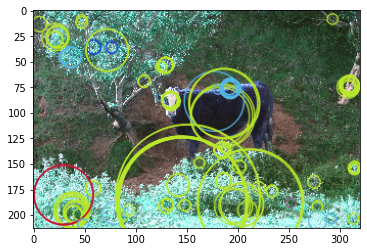

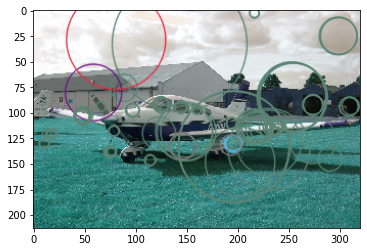

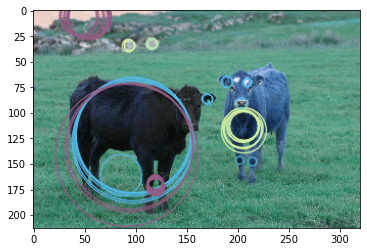

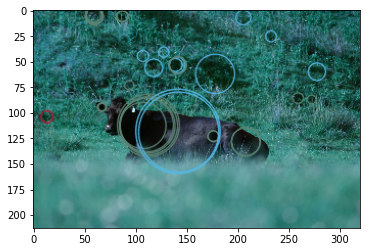

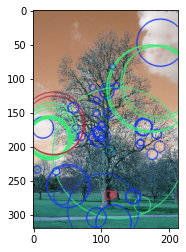

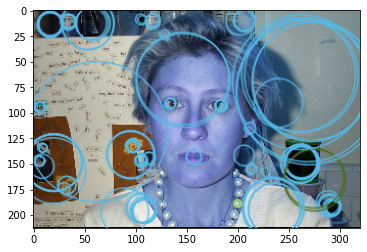

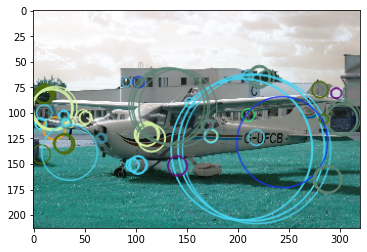

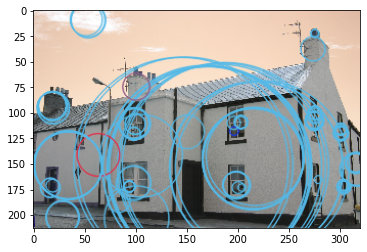

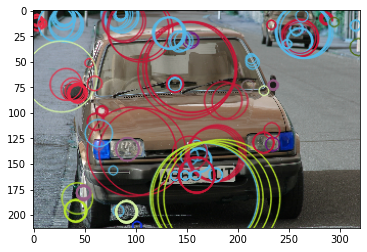

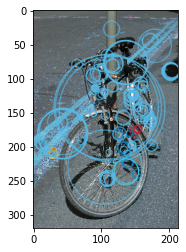

In [9]:
doLDA(picTrain, 0.15, 15)

The final step was to test the parameters, found in the learning phase, on some images used only in the test phase. 

In [10]:
i = 0
for pic in picTest:
    kp, des = mresSift(pic['pic'])
    picTest[i]['keyPoint'] = kp
    picTest[i]['descriptors'] = des
    i+=1
    
i = 0
for pic in picTest:
        code, dist = scipy.cluster.vq.vq(scipy.cluster.vq.whiten(pic["descriptors"]), picTrainWords)
        picTest[i]["code"]=code
        BoVW, _ = np.histogram(pic["code"], bins=range(picTrainWords.shape[0] + 1), normed=True)
        term_probabilitiy=[(j,elem) for j, elem in enumerate(BoVW)]
        picTest[i]["histogram"]=term_probabilitiy

        print(("elaborated BoVW for test pic ", i+1, " out of ", len(picTest)), end='\r')

        i+=1

C:\Users\super\AppData\Local\Temp\ipykernel_35996\505723776.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  BoVW, _ = np.histogram(pic["code"], bins=range(picTrainWords.shape[0] + 1), normed=True)


C:\Users\super\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\gensim\models\ldamodel.py:849: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


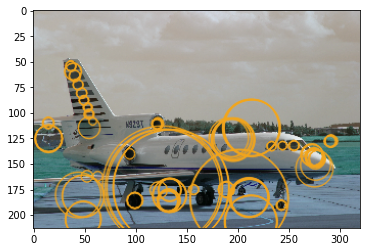

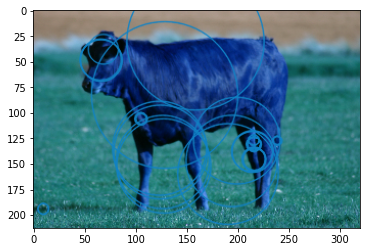

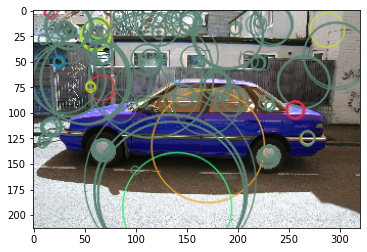

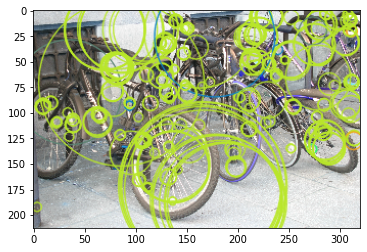

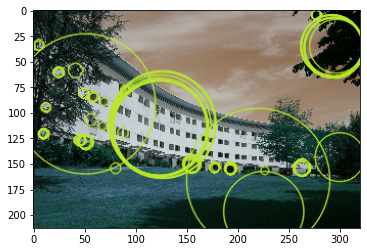

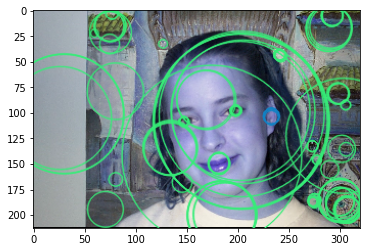

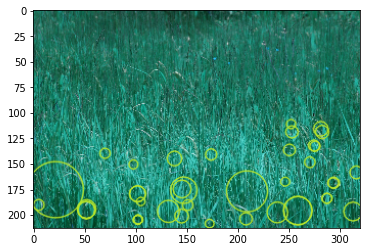

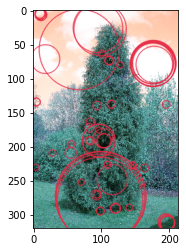

In [11]:
doLDA(picTest, 0.15, 15)

#### Section 2: Analysis  

Using the SIFT and MRES to perform a features detection and find all the interesting keypoints in the pictures has proven to be mostly successful. In most cases the selected points in the pictures avoid the background and identify the various subjects present.       

When performing the k-mean to find the clusters, to identify the topics of the pics, from the keypoints and subsequently performing the LDA something that catches the eye is that most of the topics are assigned as desired but not all of them. 
In fact, in some pictures we can see that there are different topics placed one next the other but the LDA model doesn't recognize them as different ones.



#### Section 3: Conclusions


We can deduce that the LDA model, even tho we pass some interesting keypoints, is probably not efficient and precise enough to have a clear classification of the dataset. On the other hand we can say that the LDA model, in this basic version, at least identify the main topic correctly as previously shown thanks to the pictures used in the testset.